In [2]:
import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt

The function below is used to plot mnist images

In [3]:
def show_imgs(imgs):
    """    Plot images    """
    l=6 # on lxl grid
    nimgs=l*l
    plt.rcParams['figure.figsize']=(6,6)
    g, ax = plt.subplots(l,l)
    for i in range(min(imgs.shape[0],nimgs)):
        a=i//l
        b=i%l
        ax[a][b].imshow(imgs[i,:,:],cmap='summer')
        ax[a][b].set_xticks([])
        ax[a][b].set_yticks([])

### Data loading
$100$ MNIST images have been stored as "mnist_100_28x28_p0.5.npy".

Each image contains $n=28\times 28=784$ pixels, each of which takes value $0$ or $1$.

In our settings, each image is viewed as a product state in the Hilbert space of  dimension $2^n$.

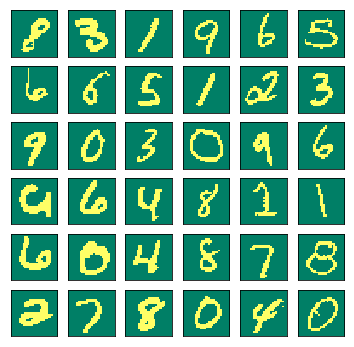

In [37]:
data=np.load("mnist_100_28x28_p0.5.npy")
show_imgs(data[:36,:,:])

n=784 # number of qubits
data=torch.LongTensor(data)
data=data.view(-1,784) # m images, each of which is reshaped into a vector of length 784

### MPS initialization
#### Define the mps, which is a list of 3-way tensors containing random values

In [38]:
tensor_type = torch.FloatTensor # 32-bit float
epsilon=1.0e-26 # epsilon for preserving accurarcy
Dmax=20 # maximum bond dimension
bond_dims=[1 if (i==0 or i==n-1) else Dmax for i in range(n)]
tensors= [ torch.randn(bond_dims[i-1],2,bond_dims[i]).type(tensor_type) for i in range(n)]

#### Now check the bond dimensions and tensors

In [39]:
print("There are len(tensors) tensors")
print(bond_dims)
print(tensors[5].shape)

There are len(tensors) tensors
[1, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2

#### Question: does the contration with one image give a probability of the image? Why?

### MPS left canonicalization
Canonicalization gives several advantages. 

First, it make the partition function of the model equals to $1$. 

Second, the isometries have condition number $1$, preserving very well the computation precisions.

In [42]:
going_right=True # a flag telling us the direction of the sweeping.
for bond in range(n-1):
    dl=bond_dims[bond-1] # left bond dimension
    d=bond_dims[bond]   # current bond dimension
    dr=bond_dims[bond+1]   # next bond dimension
    A=tensors[bond].view(dl*2,d) # A is a matrix unfolded from the current tensor
    Q,R=torch.qr(A)
    tensors[bond] = Q.contiguous().view(dl,2,-1)
    R/=R.norm() # devided by norm 
    tensors[bond+1]=torch.mm(R,tensors[bond+1].view(d,2*dr)).view(-1,2,dr)
    bond_dims[bond]=Q.shape[1] # economy QR, so the right dimension could be either dl or d

    

### Initialize cache for MPS
Computing probability of a image consists of contracting bonds from the first tensor to the last tensor. Lots of computations can be used in the near future, so we would like to cache the contraction results in the cache.
Notice that the cache is for all images.